In [278]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

pd.set_option("display.max_columns",30)

In [279]:
barbados_processed_df = pd.read_csv("station_data_processed/marshall_hourly_processed_data.csv", index_col=0)
barbados_processed_df.index = pd.to_datetime(barbados_processed_df.index, errors='coerce')



In [280]:
barbados_processed_df.head()

,bmp180_temp,bmp180_pres,bmp180_slp,bmp180_alt,bmp280_temp,bmp280_pres,bmp280_slp,bmp280_alt,bme_temp,bme_pres,bme_slp,bme_alt,bme_hum,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_dir,wind_speed
datetime,,,,,,,,,,,,,,,,,,,,,,
2017-03-01 05:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN
2017-03-01 05:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
2017-03-01 05:26:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
2017-03-01 05:27:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
2017-03-01 05:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0


In [281]:
def statistics(df, hourly = False): 
    # turn objec index into datetime index
    df.index = pd.to_datetime(df.index)

    df = df.sort_index()

    if hourly:
        full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')  # min stands for minute frequency
        time_unit  = "hour"
    else:
        # Create a complete minute-wise index
        full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='min')  # min stands for minute frequency
        time_unit  = "minute"
    
    # Reindex the dataframe to include all minutes, filling missing with NaN
    df = df.reindex(full_index) 

    # Total timespan/steps
    total_time = full_index.shape[0]

    # Actual measurements not Nan
    actual_measurements = df.notna().sum()
    relative_measurements = actual_measurements / total_time * 100

    # Non - zero measurments 
    non_zero_measurements = (df != 0).sum()
    relative_non_zero_measurements = non_zero_measurements / total_time * 100
    
    print(f"Total {time_unit}s: {total_time}")
    print(f"Total {time_unit}s: 100%")
    print(f"Actual measurements: {actual_measurements}")
    print(f"Relative measurements: {relative_measurements:.2f}%")
    print(f"Non-zero measurements: {non_zero_measurements}")
    print(f"Relative non-zero measurements: {relative_non_zero_measurements:.2f}%")
    



In [282]:
def plot_hist(df, var_name, station, save=False):

    staion_name = station
    # Create a histogram with log scale on the y-axis
    
    plt.figure(figsize=(14,6) )
    plt.hist(df[var_name], bins=50, log=True, color='mediumblue', edgecolor='black')     

    # Add labels and title
    plt.xlabel(f"{var_name.capitalize()} Bins")
    plt.ylabel("Count (Log Scale)")
    plt.title(f"{station.capitalize()}: Histogram of {var_name.capitalize()} with Log Scale")
    plt.grid(True)

    if save:
    # Check if the 'eda' directory exists, if not, create it
        save_dir = "eda"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        plt.savefig(f"eda/{staion_name}_{var_name}_hist.png")
        print(f"Figure saved as eda/{staion_name}_{var_name}_hist.png")

    # Display the plot
    plt.show()





In [283]:
summary = statistics(barbados_processed_df["tipping"])


Total minutes: 3549033
Total minutes: 100%
Actual measurements: 2759821
Relative measurements: 77.76%
Non-zero measurements: 793548
Relative non-zero measurements: 22.36%


Figure saved as eda/marshall_minutely_tipping_hist.png


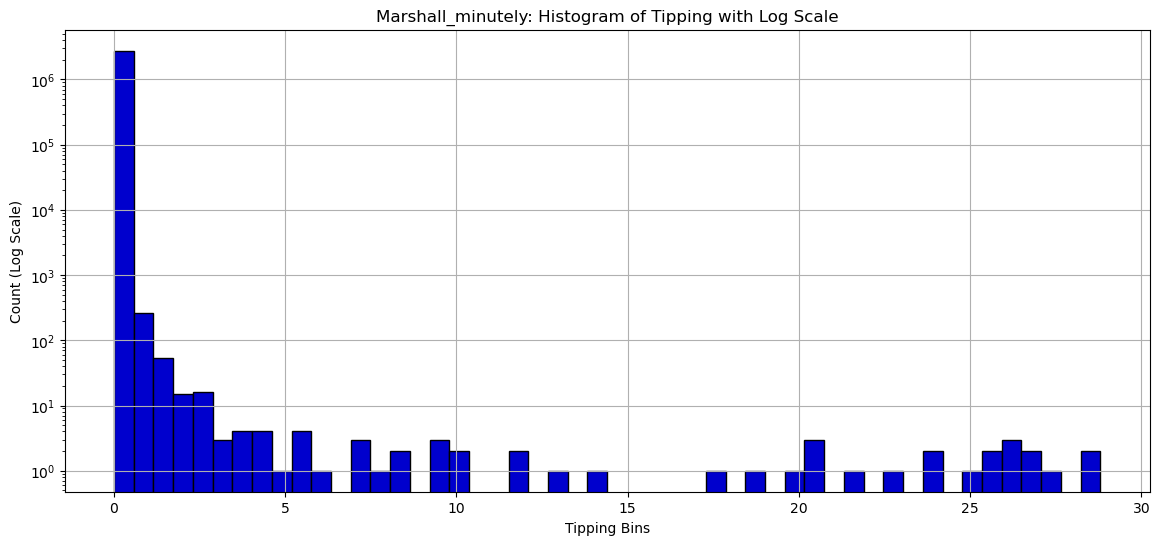

In [284]:
plot_hist(barbados_processed_df, "tipping", "marshall_minutely", save=True)

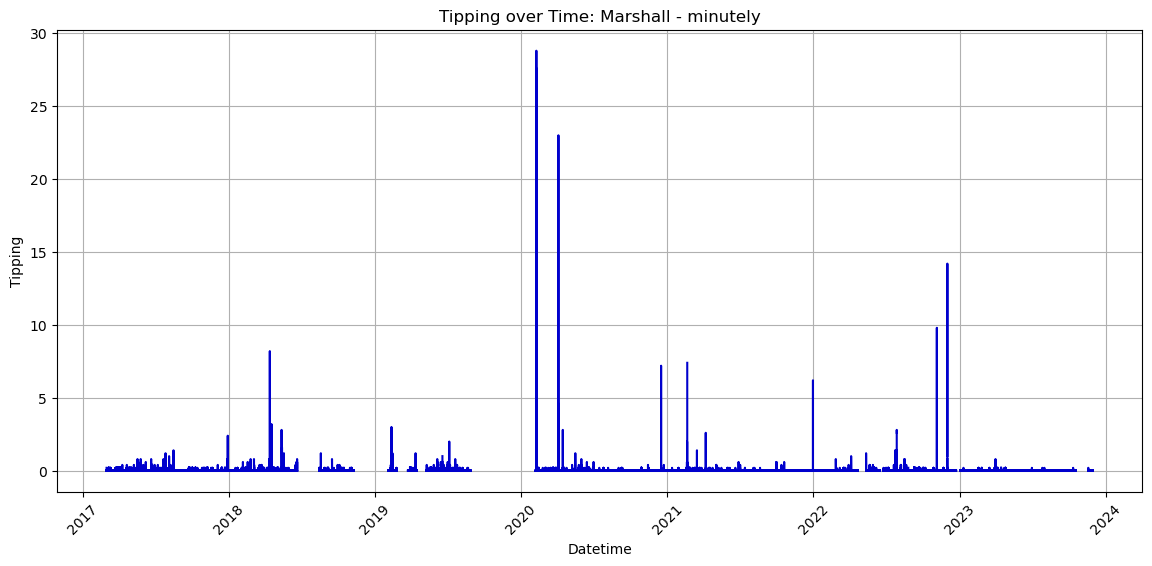

In [285]:
plt.figure(figsize=(14,6) )
plt.plot(barbados_processed_df["tipping"], color='mediumblue')
plt.xlabel("Datetime")
plt.ylabel("Tipping")
plt.title("Tipping over Time: Marshall - minutely")
plt.xticks(rotation=45)
plt.grid(True)

plt.savefig("eda/marshall_tipping_minutely_plot.png")

plt.show()

In [286]:
def circular_mean(series):
    """
    Calculate the mean direction for circular data (e.g., wind direction).
    """
    radians = np.deg2rad(series.dropna())
    sin_mean = np.nanmean(np.sin(radians))
    cos_mean = np.nanmean(np.cos(radians))
    mean_angle = np.arctan2(sin_mean, cos_mean)
    mean_angle_deg = np.rad2deg(mean_angle)
    if mean_angle_deg < 0:
        mean_angle_deg += 360
    return mean_angle_deg

def custom_aggregation(var_name):
    """
    Define custom aggregation functions for different variables during resampling.
    """
    def aggregate(series):
        # Exclude if the series has too many missing values
        if series.isna().sum() > 20:
            return np.nan
        # Exclude if the series has fewer than 3 unique values (except for 'tipping')
        if var_name != 'tipping' and series.nunique() <= 3:
            return np.nan

        if var_name == 'tipping':
            # Sum for precipitation
            return series.sum()
        elif var_name == 'wind_speed':
            # Mean for wind speed
            return series.mean()
        elif var_name == 'wind_dir':
            # Circular mean for wind direction
            return circular_mean(series)
        else:
            # Median for other variables
            return series.median()
    return aggregate

aggregation_dict = {'bmp180_temp': "mean",
                    'bmp180_pres': "mean",
                    'bmp180_slp': "mean",
                    'bmp180_alt': "mean",
                    'bmp280_temp': "mean",
                    'bmp280_pres': "mean",
                    'bmp280_slp': "mean",
                    'bmp280_alt': "mean",
                    'bme_temp': "mean",
                    'bme_pres': "mean",
                    'bme_slp': "mean",
                    'bme_alt': "mean",
                    'bme_hum': "mean",
                    'htu_temp': "mean",
                    'htu_hum': "mean",
                    'mcp9808': "mean",
                    'tipping': "sum",
                    'vis_light': "mean",
                    'ir_light': "mean",
                    'uv_light': "mean",
                    'wind_dir': "mean",
                    'wind_speed': "mean"}

In [287]:
hourly_df = pd.DataFrame()

for var_name in barbados_processed_df.columns:
    hourly_series = barbados_processed_df[var_name].resample('h').apply(custom_aggregation(var_name))
    hourly_df[var_name] = hourly_series

In [288]:
hourly_df

,bmp180_temp,bmp180_pres,bmp180_slp,bmp180_alt,bmp280_temp,bmp280_pres,bmp280_slp,bmp280_alt,bme_temp,bme_pres,bme_slp,bme_alt,bme_hum,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_dir,wind_speed
datetime,,,,,,,,,,,,,,,,,,,,,,
2017-03-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,349.383765,0.622000
2017-03-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29 15:00:00,5.30,821.250,1012.860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.7,NaN,NaN,0.0,NaN,NaN,NaN,253.115772,0.827627
2023-11-29 16:00:00,9.20,820.700,1009.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.4,NaN,NaN,0.0,NaN,NaN,NaN,112.725353,1.082069
2023-11-29 17:00:00,9.40,820.355,1008.645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.7,NaN,NaN,0.0,NaN,NaN,NaN,12.820698,1.316724


In [289]:
summary = statistics(hourly_df["tipping"], hourly=True)


Total hours: 59151
Total hours: 100%
Actual measurements: 46388
Relative measurements: 78.42%
Non-zero measurements: 13903
Relative non-zero measurements: 23.50%


Figure saved as eda/marshall_hourly_tipping_hist.png


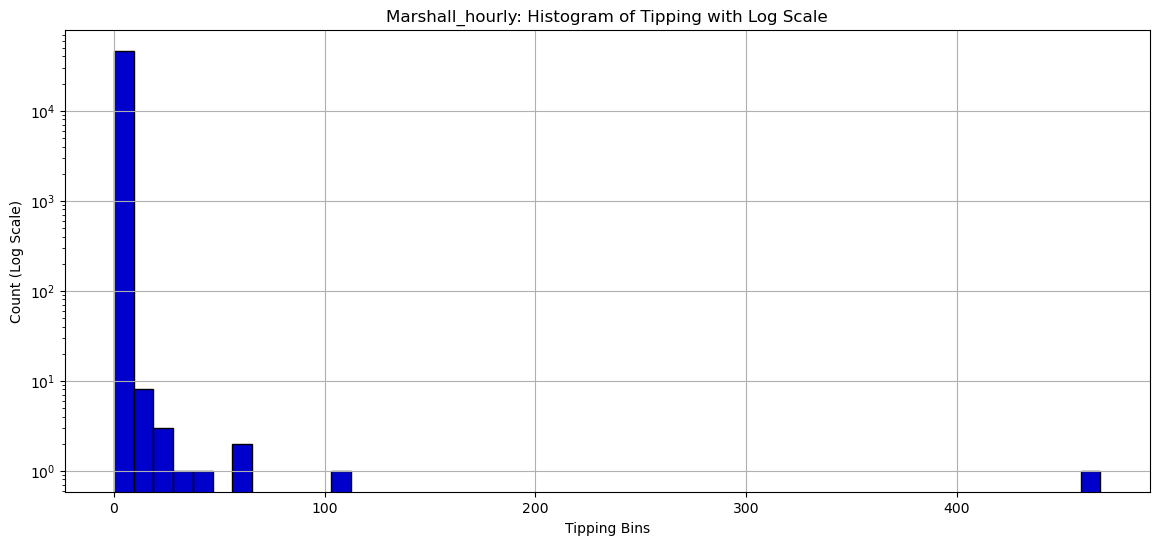

In [290]:
plot_hist(hourly_df, "tipping", "marshall_hourly", save=True)


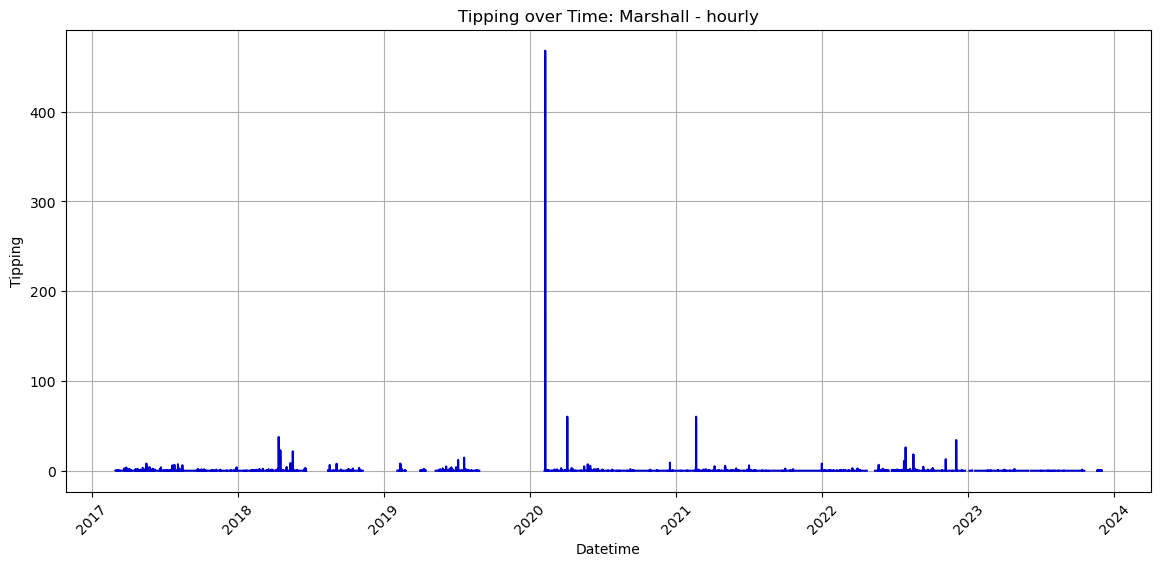

In [291]:
plt.figure(figsize=(14,6) )
plt.plot(hourly_df["tipping"], color='mediumblue')
plt.xlabel("Datetime")
plt.ylabel("Tipping")
plt.title("Tipping over Time: Marshall - hourly")
plt.xticks(rotation=45)
plt.grid(True)

plt.savefig("eda/marshall_tipping_hourly_plot.png")

plt.show()

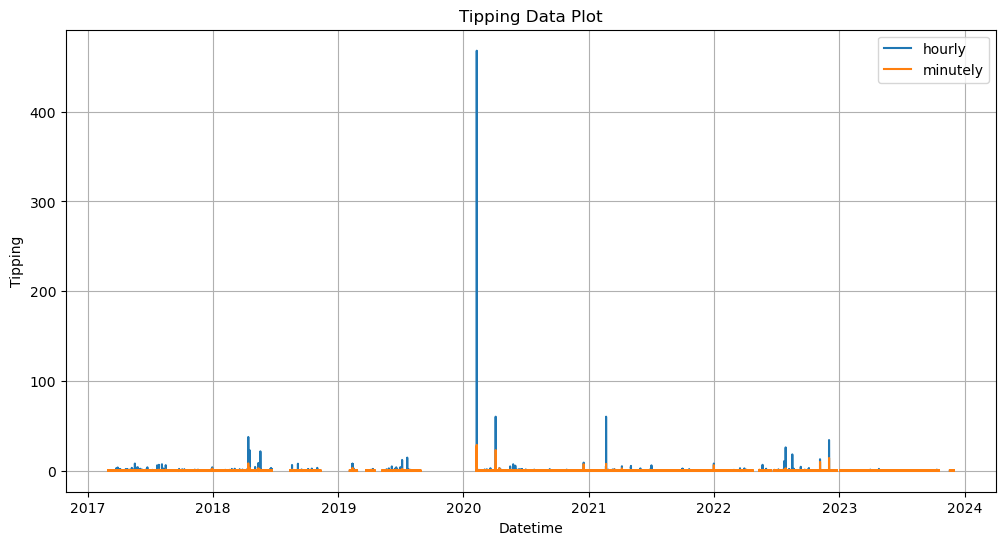

In [292]:
plt.figure(figsize=(12,6) )
plt.plot(hourly_df["tipping"], label="hourly")


plt.plot(barbados_processed_df["tipping"], label="minutely")

plt.xlabel("Datetime")
plt.ylabel("Tipping")
plt.title("Tipping Data Plot")
plt.legend()
plt.grid(True)




plt.show()

In [293]:
hourly_df = pd.DataFrame()

for var_name in barbados_processed_df.columns:
    hourly_series = barbados_processed_df[var_name].resample('h').apply(custom_aggregation(var_name))
    hourly_df[var_name] = hourly_series

In [294]:
summary = statistics(hourly_df["tipping"], hourly=True)


Total hours: 59151
Total hours: 100%
Actual measurements: 46388
Relative measurements: 78.42%
Non-zero measurements: 13903
Relative non-zero measurements: 23.50%


In [295]:
hourly_df.tail()

,bmp180_temp,bmp180_pres,bmp180_slp,bmp180_alt,bmp280_temp,bmp280_pres,bmp280_slp,bmp280_alt,bme_temp,bme_pres,bme_slp,bme_alt,bme_hum,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_dir,wind_speed
datetime,,,,,,,,,,,,,,,,,,,,,,
2023-11-29 15:00:00,5.30,821.250,1012.860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.7,NaN,NaN,0.0,NaN,NaN,NaN,253.115772,0.827627
2023-11-29 16:00:00,9.20,820.700,1009.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.4,NaN,NaN,0.0,NaN,NaN,NaN,112.725353,1.082069
2023-11-29 17:00:00,9.40,820.355,1008.645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.7,NaN,NaN,0.0,NaN,NaN,NaN,12.820698,1.316724
2023-11-29 18:00:00,10.90,819.260,1006.120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5,NaN,NaN,0.0,NaN,NaN,NaN,33.629376,1.298136
2023-11-29 19:00:00,11.05,818.630,1005.665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.2,NaN,NaN,0.0,NaN,NaN,NaN,231.578200,1.433818


In [296]:
hourly_series = barbados_raw_df["tipping"].resample('h').apply(custom_aggregation('tipping'))
hourly_series

NameError: name 'barbados_raw_df' is not defined